## Feature set 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import librosa
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import EarlyStopping

from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,merge,Activation

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


#### Extracting data from csv files into numpy arrays

In [2]:
#extracting data from csv files into numpy arrays
from numpy import genfromtxt
files_data=np.array(['fold_data_1.csv','fold_data_2.csv','fold_data_3.csv','fold_data_4.csv','fold_data_5.csv',
                'fold_data_6.csv','fold_data_7.csv','fold_data_8.csv','fold_data_9.csv','fold_data_10.csv'])
X_folds= np.array([genfromtxt(file,delimiter=',') for file in files_data])

files_label=(['fold_labels_1.csv','fold_labels_2.csv','fold_labels_3.csv','fold_labels_4.csv','fold_labels_5.csv',
                'fold_labels_6.csv','fold_labels_7.csv','fold_labels_8.csv','fold_labels_9.csv','fold_labels_10.csv'])
Y_folds= np.array([genfromtxt(file,delimiter=',') for file in files_label])

In [3]:
def data_processor_cnn(X_fold,Y_fold):
    X_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn=([to_categorical(Y_fold, num_classes=10) for Y_fold in Y_fold])
    for i in range(0, len(X_fold)):
        X_fold_processor_cnn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 24, 4, 1))
    return X_fold_processor_cnn,Y_fold_processor_cnn

In [4]:
def data_processor_basic_nn(X_fold,Y_fold):
    X_fold_basic_nn = [0]*10
    Y_fold_basic_nn = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_basic_nn[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_basic_nn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 24, 4))
    return X_fold_basic_nn,Y_fold_basic_nn

In [5]:
def data_processor_log_reg(X_fold,Y_fold):
    X_fold_log_reg = [0]*10
    Y_fold_log_reg = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_log_reg[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_log_reg[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 96))
    return X_fold_log_reg,Y_fold_log_reg

In [6]:
Data_cnn=data_processor_cnn(X_folds,Y_folds)
X_folds_10=Data_cnn[0]
Y_folds_10=Data_cnn[1]

In [7]:
Data_nn=data_processor_basic_nn(X_folds,Y_folds)
X_folds_1=Data_nn[0]
Y_folds_1=Data_nn[1]

In [8]:
Data_Linear=data_processor_log_reg(X_folds,Y_folds)
X_folds_2=Data_Linear[0]
Y_folds_2=Data_Linear[1]

##### shapes of data

In [9]:
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_10[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_10[i]))
    
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_1[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_1[i]))

X_data 1 = (873, 24, 4, 1)
Y_data 1 = (873, 10)
X_data 2 = (888, 24, 4, 1)
Y_data 2 = (888, 10)
X_data 3 = (925, 24, 4, 1)
Y_data 3 = (925, 10)
X_data 4 = (990, 24, 4, 1)
Y_data 4 = (990, 10)
X_data 5 = (936, 24, 4, 1)
Y_data 5 = (936, 10)
X_data 6 = (823, 24, 4, 1)
Y_data 6 = (823, 10)
X_data 7 = (838, 24, 4, 1)
Y_data 7 = (838, 10)
X_data 8 = (806, 24, 4, 1)
Y_data 8 = (806, 10)
X_data 9 = (816, 24, 4, 1)
Y_data 9 = (816, 10)
X_data 10 = (837, 24, 4, 1)
Y_data 10 = (837, 10)
X_data 1 = (873, 24, 4)
Y_data 1 = (873, 1)
X_data 2 = (888, 24, 4)
Y_data 2 = (888, 1)
X_data 3 = (925, 24, 4)
Y_data 3 = (925, 1)
X_data 4 = (990, 24, 4)
Y_data 4 = (990, 1)
X_data 5 = (936, 24, 4)
Y_data 5 = (936, 1)
X_data 6 = (823, 24, 4)
Y_data 6 = (823, 1)
X_data 7 = (838, 24, 4)
Y_data 7 = (838, 1)
X_data 8 = (806, 24, 4)
Y_data 8 = (806, 1)
X_data 9 = (816, 24, 4)
Y_data 9 = (816, 1)
X_data 10 = (837, 24, 4)
Y_data 10 = (837, 1)


# Defining Functions
## Simple nn function

In [10]:

def Model_run_nn(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array, 
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
   
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,batch_size=Batch_size,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [11]:
def Model_run_nn_es(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 24, 4, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0, callbacks=[early_stopping_cb])
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

### Graph function

In [12]:
def Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,Val_loss_array):
    %matplotlib inline
    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Epoch_array_accuracy[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Val Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Val_accuracy_array[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(Loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Val Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Val Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(Val_Loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Table function

In [13]:
def table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time):
    data= {'Fold': ['1','2','3','4','5','6','7','8','9','10'],
           'Accuracy': [Fold_accuracy[0],Fold_accuracy[1],Fold_accuracy[2],Fold_accuracy[3],Fold_accuracy[4],
                    Fold_accuracy[5],Fold_accuracy[6],Fold_accuracy[7],Fold_accuracy[8],Fold_accuracy[9]],
           'Time Taken' :[end_array[0],end_array[1],end_array[2],end_array[3],end_array[4],end_array[5],end_array[6],end_array[7],
                end_array[8],end_array[9]]}
    df = pd.DataFrame(data, columns = ['Fold', 'Accuracy','Time Taken'])
    data_avg={'Average Accuracy':[Avg_Accuracy],'Total Time':[Time]}
    df_avg=pd.DataFrame(data_avg,columns=['Average Accuracy','Total Time'])
    print (df)
    print ("\n",df_avg)

### Average graph function

In [14]:
def Graph_Avg_maker(Fold_accuracy,Avg_Accuracy):
    %matplotlib inline
    Fold_iteration=np.linspace(1,10,num=10)
    fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    ax1.plot(Fold_iteration,Fold_accuracy,"gx")
    ax1.axhline(y=Avg_Accuracy,label='Average Accuracy')
    fig.suptitle(f"Results for Batch size of {Batch_size}\n and Epoch number of {Epoch_number}\n for Feature set 1")
    ax1.set_xlabel("Fold iteration")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Confusion matrix function

In [15]:
import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def Confusion_matrix(x_test, y_test_a, model=None):

    if model == None:
        return 'Please pass a defined model to this function'
    
    # Create predictions
    try:
        y_test_pred = model.predict_classes(x_test)
    except:
        y_test_pred = model.predict(x_test)
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Create confusion matrix
    array = sklearn.metrics.confusion_matrix(y_test_a, y_test_pred)

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [16]:
def plot_confusion_matrix(cm):
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Read confusion matrix
    array = cm

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [17]:
def average_confusion_matrix(X):
    # Returns the average confusion matrix for the 10-fold cross-validation results
    avg_cm = (X[0]+X[1]+X[2]+X[3]+X[4]+X[5]+X[6]+X[7]+X[8]+X[9])
    return avg_cm

## Model 1

In [18]:
model=Sequential()
model.add(Flatten(input_shape=[24, 4]))
model.add(Dense(300, activation="relu"))   
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))
Model=model.compile(loss = "sparse_categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [19]:
Accuracy_array=[]
accuracy_total=0
end_array=[]
Epoch_array_accuracy=[]
Loss_array=[]
Fold_accuracy=[]
Val_accuracy_array=[]
Val_Loss_array=[]
Avg_Accuracy=[]
Time=[]
accuracy_score=[]
Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Epoch_number=50
Batch_size=30

Model=Model_run_nn(Model,model,X_folds_1,Y_folds_1,Accuracy_array,
                   accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
                   Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
                   Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)

Avg_Accuracy=Model[0]
Time=Model[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4) (7859, 1) (873, 24, 4) (873, 1)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.2445603609085083
Time to train Fold 1 : 41.6055 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4) (7844, 1) (888, 24, 4) (888, 1)
Accuracy of Fold 2 is 0.18379907310009003
Time to train Fold 2 : 37.5457 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4) (7807, 1) (925, 24, 4) (925, 1)
Accuracy of Fold 3 is 0.17618803679943085
Time to train Fold 3 : 36.2685 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4) (7742, 1) (990, 24, 4) (990, 1)
Accuracy of Fold 4 is 0.18122705817222595
Time to train Fold 4 : 36.8946 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4) (7796, 1) (936, 24, 4) (936, 1)
Accuracy of Fold 5 is 0.19501538574695587
Time to train Fold 5 : 37.4431 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4) (7909, 1) (823, 24, 4) (823, 1)
Accuracy of Fold 6 is 0.2222379744052887
Time to train Fold 6 : 36.6099 seconds.

Fold #7
- - - - - - - - - - - - - 

In [20]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.09432829439089191, 0.1824893138909112, 0.1764032073310424, 0.1764032073310424
2, 0.13007771705655044, 0.2765436903082094, 0.20833333333333334, 0.20833333333333334
3, 0.12598508309084783, 0.18421520634584718, 0.18702702702702703, 0.18702702702702703
4, 0.2033563431961568, 0.32117156325597834, 0.24646464646464647, 0.24646464646464647
5, 0.09708805171334443, 0.17182724682724682, 0.16132478632478633, 0.16132478632478633
6, 0.09766678993659929, 0.22720490559623266, 0.1421628189550425, 0.1421628189550425
7, 0.0244858778014876, 0.22664159841577813, 0.0954653937947494, 0.0954653937947494
8, 0.17290288985378574, 0.3265284782025518, 0.21836228287841192, 0.21836228287841192
9, 0.21191790015672082, 0.3291053244689205, 0.24877450980392157, 0.24877450980392157
10, 0.08329324802644067, 0.21230344167838858, 0.14934289127837516, 0.14934289127837516


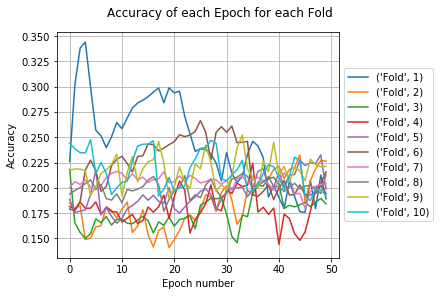

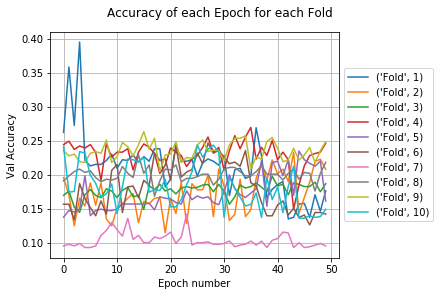

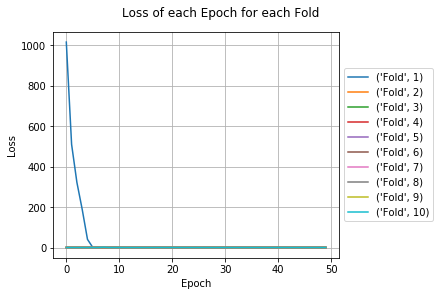

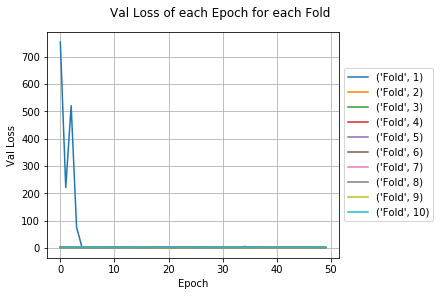

In [21]:
Graph_Epochs_model_1=Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,Val_Loss_array)

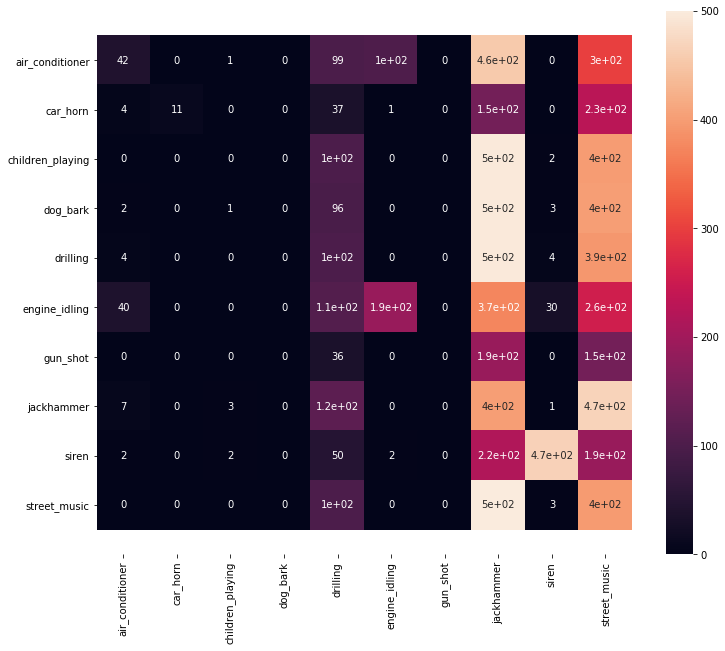

In [22]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [23]:
Table_model_1=table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time)

  Fold  Accuracy  Time Taken
0    1  0.244560     41.6055
1    2  0.183799     37.5457
2    3  0.176188     36.2685
3    4  0.181227     36.8946
4    5  0.195015     37.4431
5    6  0.222238     36.6099
6    7  0.205974     36.2761
7    8  0.199937     37.1479
8    9  0.217218     36.2679
9   10  0.217077     36.7876

    Average Accuracy  Total Time
0          0.204323    372.8468


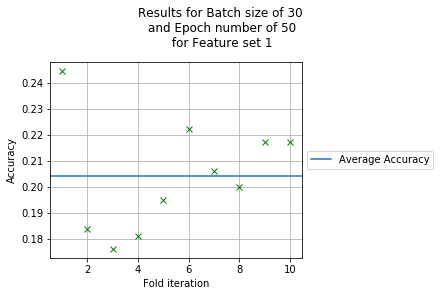

In [24]:
Graph_Avg_model_1=Graph_Avg_maker(Fold_accuracy,Avg_Accuracy)

### Model 1 no cross validation

In [25]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 24, 4))

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds_1[j] for j in range(0, len(Y_folds_1)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

Epoch_number=30

#compile model using accuracy to measure model performance
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
cnn_model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_1_no_cross=model.evaluate(X_test, y_test)
accuracy_model_1_no_cross = score_model_1_no_cross[1]
print(f"\nAccuracy of model 1 with no cross validation: {round(accuracy_model_1_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 2s - loss: 1.9122 - accuracy: 0.31 - ETA: 1s - loss: 2.0349 - accuracy: 0.22 - ETA: 1s - loss: 2.0202 - accuracy: 0.21 - ETA: 0s - loss: 2.0204 - accuracy: 0.20 - ETA: 0s - loss: 2.0436 - accuracy: 0.20 - ETA: 0s - loss: 2.0365 - accuracy: 0.20 - ETA: 0s - loss: 2.0316 - accuracy: 0.20 - ETA: 0s - loss: 2.0334 - accuracy: 0.20 - ETA: 0s - loss: 2.0311 - accuracy: 0.20 - ETA: 0s - loss: 2.0406 - accuracy: 0.20 - 1s 69us/step - loss: 2.0462 - accuracy: 0.2048 - val_loss: 2.2535 - val_accuracy: 0.1386
Epoch 2/30
7895/7895 [==============================] - ETA: 0s - loss: 2.0493 - accuracy: 0.21 - ETA: 0s - loss: 2.0899 - accuracy: 0.18 - ETA: 0s - loss: 2.0578 - accuracy: 0.20 - ETA: 0s - loss: 2.0537 - accuracy: 0.20 - ETA: 0s - loss: 2.0483 - accuracy: 0.20 - ETA: 0s - loss: 2.0502 - accuracy: 0.20 - ETA: 0s - loss: 2.0437 - accuracy: 0.20 - ETA: 0s - loss: 2.0529 - accuracy: 0.2

7895/7895 [==============================] - ETA: 0s - loss: 1.8134 - accuracy: 0.34 - ETA: 0s - loss: 1.8759 - accuracy: 0.27 - ETA: 0s - loss: 1.8915 - accuracy: 0.26 - ETA: 0s - loss: 1.8902 - accuracy: 0.27 - ETA: 0s - loss: 1.9158 - accuracy: 0.26 - ETA: 0s - loss: 1.9093 - accuracy: 0.25 - ETA: 0s - loss: 1.9134 - accuracy: 0.25 - ETA: 0s - loss: 1.9167 - accuracy: 0.25 - ETA: 0s - loss: 1.9205 - accuracy: 0.25 - ETA: 0s - loss: 1.9374 - accuracy: 0.25 - ETA: 0s - loss: 1.9454 - accuracy: 0.24 - 1s 70us/step - loss: 1.9449 - accuracy: 0.2478 - val_loss: 2.1097 - val_accuracy: 0.1828
Epoch 14/30
7895/7895 [==============================] - ETA: 0s - loss: 2.1162 - accuracy: 0.21 - ETA: 0s - loss: 1.9781 - accuracy: 0.24 - ETA: 0s - loss: 2.0038 - accuracy: 0.22 - ETA: 0s - loss: 1.9918 - accuracy: 0.22 - ETA: 0s - loss: 2.0011 - accuracy: 0.22 - ETA: 0s - loss: 2.0017 - accuracy: 0.22 - ETA: 0s - loss: 1.9989 - accuracy: 0.22 - ETA: 0s - loss: 2.0010 - accuracy: 0.22 - ETA: 0s - l

7895/7895 [==============================] - ETA: 1s - loss: 2.1547 - accuracy: 0.06 - ETA: 0s - loss: 2.0255 - accuracy: 0.21 - ETA: 0s - loss: 2.0353 - accuracy: 0.20 - ETA: 0s - loss: 2.0546 - accuracy: 0.19 - ETA: 0s - loss: 2.0390 - accuracy: 0.19 - ETA: 0s - loss: 2.0354 - accuracy: 0.20 - ETA: 0s - loss: 2.0269 - accuracy: 0.20 - ETA: 0s - loss: 2.0166 - accuracy: 0.21 - ETA: 0s - loss: 2.0089 - accuracy: 0.21 - ETA: 0s - loss: 2.0028 - accuracy: 0.21 - ETA: 0s - loss: 1.9970 - accuracy: 0.21 - ETA: 0s - loss: 1.9907 - accuracy: 0.22 - 1s 77us/step - loss: 1.9888 - accuracy: 0.2209 - val_loss: 2.1570 - val_accuracy: 0.1912
Epoch 24/30
7895/7895 [==============================] - ETA: 0s - loss: 1.9066 - accuracy: 0.21 - ETA: 0s - loss: 1.9475 - accuracy: 0.24 - ETA: 0s - loss: 1.9600 - accuracy: 0.25 - ETA: 0s - loss: 1.9401 - accuracy: 0.25 - ETA: 0s - loss: 1.9392 - accuracy: 0.25 - ETA: 0s - loss: 1.9392 - accuracy: 0.24 - ETA: 0s - loss: 1.9319 - accuracy: 0.24 - ETA: 0s - l

## Model 2

In [26]:
#adding layers and forming the model_1
#forming model_1
model_2=Sequential()
early_stopping_cb = EarlyStopping(patience=16, restore_best_weights=True)

    #add model layers
model_2.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(24,4,1)))
#model_2.add(Conv2D(32, kernel_size=3, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(10, activation='softmax'))
    #compile model using accuracy to measure model performance
Model_2=model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
Accuracy_array_2=[]
accuracy_total_2=0
end_array_2=[]

Epoch_array_accuracy_2=[]
Loss_array_2=[]
Fold_accuracy_2=[]

Val_accuracy_array_2=[]
Val_Loss_array_2=[]

Avg_Accuracy_2=[]
Time_2=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_2=Model_run_nn_es(Model_2,model_2,X_folds_10,Y_folds_10,Accuracy_array_2,
                     accuracy_total_2,end_array_2,Epoch_array_accuracy_2,Loss_array_2,
                     Fold_accuracy_2,Val_accuracy_array_2,Val_Loss_array_2, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_2=Model_2[0]
Time_2=Model_2[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4, 1) (7859, 10) (873, 24, 4, 1) (873, 10)
Accuracy of Fold 1 is 0.827168881893158
Time to train Fold 1 : 51.0317 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4, 1) (7844, 10) (888, 24, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.944937527179718
Time to train Fold 2 : 22.9157 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4, 1) (7807, 10) (925, 24, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.9477036595344543
Time to train Fold 3 : 17.9771 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4, 1) (7742, 10) (990, 24, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.9523990154266357
Time to train Fold 4 : 20.777 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4, 1) (7796, 10) (936, 24, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.9514607787132263
Time to train Fold 5 : 21.267 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4, 1) (7909, 10) (823, 2

In [28]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
0, 0.5988122279923037, 0.6191851360483234, 0.6208476517754868, 0.6208476517754868
1, 0.9075080399548551, 0.9101004344854932, 0.9076576576576577, 0.9076576576576577
2, 0.9006035785457042, 0.9067489915608627, 0.9016216216216216, 0.9016216216216216
3, 0.9124378558889253, 0.918690143637106, 0.9111111111111111, 0.9111111111111111
4, 0.9452875710634858, 0.9485959099436441, 0.9465811965811965, 0.9465811965811965
5, 0.93399114022524, 0.9350727775698128, 0.9343863912515188, 0.9343863912515188
6, 0.9441807761338185, 0.9474135293421297, 0.9439140811455847, 0.9439140811455847
7, 0.9150904261148818, 0.9177734484031048, 0.9143920595533499, 0.9143920595533499
8, 0.940445190037873, 0.9436484221341586, 0.9399509803921569, 0.9399509803921569
9, 0.9665343908507894, 0.9669705523776794, 0.966547192353644, 0.966547192353644


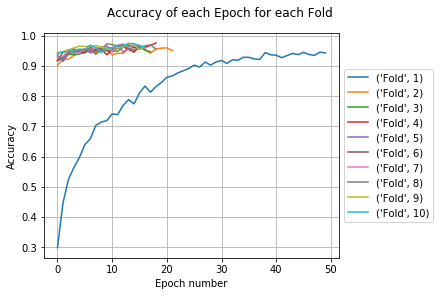

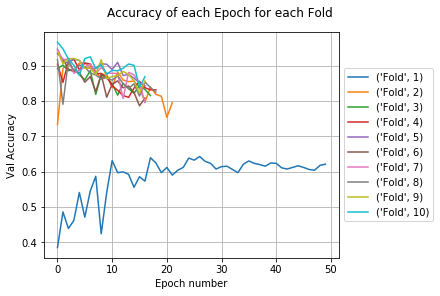

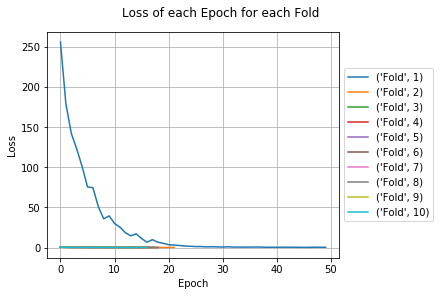

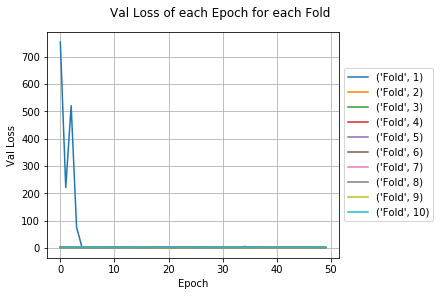

In [29]:
Graph_Epochs_model_2=Graph_func(Epoch_number,Epoch_array_accuracy_2,Val_accuracy_array_2,Loss_array_2,Val_Loss_array_2)

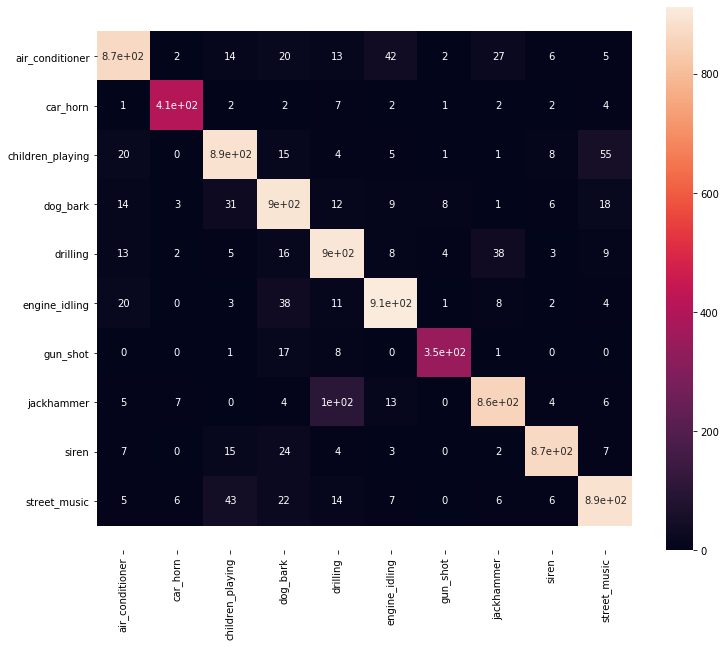

In [30]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [31]:
Table_model_2=table_maker(Fold_accuracy_2,end_array_2,Avg_Accuracy_2,Time_2)

  Fold  Accuracy  Time Taken
0    1  0.827169     51.0317
1    2  0.944938     22.9157
2    3  0.947704     17.9771
3    4  0.952399     20.7770
4    5  0.951461     21.2670
5    6  0.953493     21.2030
6    7  0.955245     21.8827
7    8  0.954819     23.9426
8    9  0.961032     21.6323
9   10  0.959192     21.8774

    Average Accuracy  Total Time
0          0.940745    244.5065


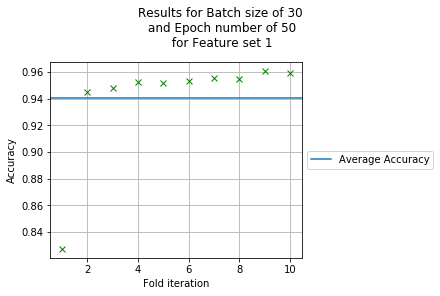

In [32]:
Graph_Avg_model_2=Graph_Avg_maker(Fold_accuracy_2,Avg_Accuracy_2)

### Model 2 no cross validation

In [33]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 24, 4,1))

Epoch_number=30
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

cnn_model_2_history = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_2_no_cross=model_2.evaluate(X_test, y_test)
accuracy_model_2_no_cross = score_model_2_no_cross[1]
print(f"\nAccuracy of model 2 with no cross validation: {round(accuracy_model_2_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 2s - loss: 0.1266 - accuracy: 0.93 - ETA: 1s - loss: 0.1791 - accuracy: 0.94 - ETA: 1s - loss: 0.2825 - accuracy: 0.93 - ETA: 1s - loss: 0.3216 - accuracy: 0.94 - ETA: 1s - loss: 0.3571 - accuracy: 0.94 - ETA: 1s - loss: 0.3173 - accuracy: 0.94 - ETA: 1s - loss: 0.3038 - accuracy: 0.94 - ETA: 0s - loss: 0.3053 - accuracy: 0.94 - ETA: 0s - loss: 0.3261 - accuracy: 0.94 - ETA: 0s - loss: 0.3197 - accuracy: 0.94 - ETA: 0s - loss: 0.3063 - accuracy: 0.95 - ETA: 0s - loss: 0.2965 - accuracy: 0.95 - ETA: 0s - loss: 0.2977 - accuracy: 0.94 - ETA: 0s - loss: 0.3009 - accuracy: 0.94 - ETA: 0s - loss: 0.3009 - accuracy: 0.94 - ETA: 0s - loss: 0.3024 - accuracy: 0.94 - ETA: 0s - loss: 0.3010 - accuracy: 0.94 - ETA: 0s - loss: 0.2926 - accuracy: 0.94 - ETA: 0s - loss: 0.2978 - accuracy: 0.94 - ETA: 0s - loss: 0.2918 - accuracy: 0.94 - ETA: 0s - loss: 0.2888 - accuracy: 0.94 - ETA: 0s - loss:

7895/7895 [==============================] - ETA: 1s - loss: 0.0068 - accuracy: 1.00 - ETA: 1s - loss: 0.1736 - accuracy: 0.94 - ETA: 1s - loss: 0.2241 - accuracy: 0.94 - ETA: 1s - loss: 0.2282 - accuracy: 0.94 - ETA: 1s - loss: 0.2276 - accuracy: 0.95 - ETA: 1s - loss: 0.2292 - accuracy: 0.95 - ETA: 1s - loss: 0.2079 - accuracy: 0.95 - ETA: 1s - loss: 0.2045 - accuracy: 0.95 - ETA: 1s - loss: 0.1998 - accuracy: 0.95 - ETA: 0s - loss: 0.1964 - accuracy: 0.95 - ETA: 0s - loss: 0.1979 - accuracy: 0.95 - ETA: 0s - loss: 0.2119 - accuracy: 0.95 - ETA: 0s - loss: 0.2028 - accuracy: 0.95 - ETA: 0s - loss: 0.2082 - accuracy: 0.95 - ETA: 0s - loss: 0.2065 - accuracy: 0.95 - ETA: 0s - loss: 0.2034 - accuracy: 0.95 - ETA: 0s - loss: 0.1978 - accuracy: 0.95 - ETA: 0s - loss: 0.1932 - accuracy: 0.95 - ETA: 0s - loss: 0.1963 - accuracy: 0.95 - ETA: 0s - loss: 0.1927 - accuracy: 0.95 - ETA: 0s - loss: 0.1866 - accuracy: 0.95 - ETA: 0s - loss: 0.1838 - accuracy: 0.96 - ETA: 0s - loss: 0.1826 - accura

7895/7895 [==============================] - ETA: 0s - loss: 0.4095 - accuracy: 0.96 - ETA: 1s - loss: 0.1611 - accuracy: 0.96 - ETA: 1s - loss: 0.1469 - accuracy: 0.96 - ETA: 1s - loss: 0.2055 - accuracy: 0.96 - ETA: 1s - loss: 0.1717 - accuracy: 0.96 - ETA: 1s - loss: 0.2110 - accuracy: 0.96 - ETA: 1s - loss: 0.2171 - accuracy: 0.96 - ETA: 1s - loss: 0.2401 - accuracy: 0.95 - ETA: 1s - loss: 0.2368 - accuracy: 0.95 - ETA: 1s - loss: 0.2255 - accuracy: 0.95 - ETA: 1s - loss: 0.2331 - accuracy: 0.95 - ETA: 0s - loss: 0.2272 - accuracy: 0.95 - ETA: 0s - loss: 0.2270 - accuracy: 0.95 - ETA: 0s - loss: 0.2163 - accuracy: 0.96 - ETA: 0s - loss: 0.2077 - accuracy: 0.96 - ETA: 0s - loss: 0.2000 - accuracy: 0.96 - ETA: 0s - loss: 0.1960 - accuracy: 0.96 - ETA: 0s - loss: 0.1876 - accuracy: 0.96 - ETA: 0s - loss: 0.1834 - accuracy: 0.96 - ETA: 0s - loss: 0.1788 - accuracy: 0.96 - ETA: 0s - loss: 0.1872 - accuracy: 0.96 - ETA: 0s - loss: 0.1802 - accuracy: 0.96 - ETA: 0s - loss: 0.1771 - accura

7895/7895 [==============================] - ETA: 2s - loss: 0.1126 - accuracy: 0.96 - ETA: 1s - loss: 0.1698 - accuracy: 0.96 - ETA: 1s - loss: 0.1347 - accuracy: 0.97 - ETA: 1s - loss: 0.1111 - accuracy: 0.97 - ETA: 1s - loss: 0.1009 - accuracy: 0.97 - ETA: 1s - loss: 0.0824 - accuracy: 0.97 - ETA: 1s - loss: 0.0889 - accuracy: 0.97 - ETA: 1s - loss: 0.0942 - accuracy: 0.97 - ETA: 1s - loss: 0.0922 - accuracy: 0.97 - ETA: 1s - loss: 0.1085 - accuracy: 0.97 - ETA: 1s - loss: 0.1452 - accuracy: 0.96 - ETA: 0s - loss: 0.1447 - accuracy: 0.96 - ETA: 0s - loss: 0.1892 - accuracy: 0.96 - ETA: 0s - loss: 0.2151 - accuracy: 0.96 - ETA: 0s - loss: 0.2104 - accuracy: 0.96 - ETA: 0s - loss: 0.2045 - accuracy: 0.96 - ETA: 0s - loss: 0.1985 - accuracy: 0.96 - ETA: 0s - loss: 0.2375 - accuracy: 0.96 - ETA: 0s - loss: 0.2375 - accuracy: 0.96 - ETA: 0s - loss: 0.2535 - accuracy: 0.96 - ETA: 0s - loss: 0.2572 - accuracy: 0.96 - ETA: 0s - loss: 0.2544 - accuracy: 0.95 - ETA: 0s - loss: 0.2549 - accura

7895/7895 [==============================] - ETA: 1s - loss: 3.9627e-04 - accuracy: 1.00 - ETA: 1s - loss: 0.1913 - accuracy: 0.9719   - ETA: 1s - loss: 0.1961 - accuracy: 0.96 - ETA: 1s - loss: 0.1633 - accuracy: 0.96 - ETA: 0s - loss: 0.1648 - accuracy: 0.96 - ETA: 0s - loss: 0.1554 - accuracy: 0.96 - ETA: 0s - loss: 0.1548 - accuracy: 0.96 - ETA: 0s - loss: 0.1418 - accuracy: 0.96 - ETA: 0s - loss: 0.1459 - accuracy: 0.96 - ETA: 0s - loss: 0.1582 - accuracy: 0.96 - ETA: 0s - loss: 0.1524 - accuracy: 0.96 - ETA: 0s - loss: 0.1422 - accuracy: 0.96 - ETA: 0s - loss: 0.1576 - accuracy: 0.96 - ETA: 0s - loss: 0.1652 - accuracy: 0.96 - ETA: 0s - loss: 0.1623 - accuracy: 0.96 - ETA: 0s - loss: 0.1551 - accuracy: 0.96 - ETA: 0s - loss: 0.1554 - accuracy: 0.96 - ETA: 0s - loss: 0.1501 - accuracy: 0.96 - ETA: 0s - loss: 0.1550 - accuracy: 0.96 - ETA: 0s - loss: 0.1653 - accuracy: 0.96 - ETA: 0s - loss: 0.1719 - accuracy: 0.96 - 1s 146us/step - loss: 0.1716 - accuracy: 0.9658 - val_loss: 1.476

## Model 3

In [34]:
model_3=Sequential()
early_stopping_cb = EarlyStopping(patience=17, restore_best_weights=True)

model_3.add(Conv2D(32,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(24,4,1)))
model_3.add(MaxPooling2D(padding="same"))

model_3.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="relu"))
model_3.add(MaxPooling2D(padding="same"))
model_3.add(Dropout(0.2))

model_3.add(Flatten())

model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))

model_3.add(Dense(10,activation="softmax"))

    #compiling
Model_3=model_3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [35]:
accuracy_total_3=0
end_array_3=[]

Epoch_array_accuracy_3=[]
Loss_array_3=[]
Fold_accuracy_3=[]

Val_accuracy_array_3=[]
Val_Loss_array_3=[]

Accuracy_array_3=[]
Avg_Accuracy_3=[]
Time_3=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_3=Model_run_nn_es(Model_3,model_3,X_folds_10,Y_folds_10,Accuracy_array_3,
                     accuracy_total_3,end_array_3,Epoch_array_accuracy_3,Loss_array_3,
                     Fold_accuracy_3,Val_accuracy_array_3,Val_Loss_array_3, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_3=Model_3[0]
Time_3=Model_3[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4, 1) (7859, 10) (873, 24, 4, 1) (873, 10)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.4557526707649231
Time to train Fold 1 : 196.3186 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4, 1) (7844, 10) (888, 24, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.6666333079338074
Time to train Fold 2 : 111.3886 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4, 1) (7807, 10) (925, 24, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.7601680159568787
Time to train Fold 3 : 77.5024 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4, 1) (7742, 10) (990, 24, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.7381454706192017
Time to train Fold 4 : 73.6696 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4, 1) (7796, 10) (936, 24, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.787390947341919
Time to train Fold 5 : 71.5815 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4, 1) (7909, 10) (823, 24, 4, 1) (823, 10)
Accuracy of Fold 6 is 0.7940055727958679
Time to train Fold 6 : 63.4935 seconds

In [36]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.2124988634054968, 0.2782760963073405, 0.27491408934707906, 0.27491408934707906
2, 0.7293552988846013, 0.7637357314438832, 0.7286036036036037, 0.7286036036036037
3, 0.7769981354510932, 0.781387822693384, 0.7762162162162162, 0.7762162162162162
4, 0.8015799574776, 0.8137735482068071, 0.807070707070707, 0.807070707070707
5, 0.8134642266286666, 0.825335082477834, 0.8141025641025641, 0.8141025641025641
6, 0.7612773469879478, 0.7656845138250875, 0.7606318347509113, 0.7606318347509113
7, 0.850838305851414, 0.8582668112827971, 0.850835322195704, 0.850835322195704
8, 0.8334724894472076, 0.8372967542147627, 0.8349875930521092, 0.8349875930521092
9, 0.8319038261845632, 0.8369097943188434, 0.8333333333333334, 0.8333333333333334
10, 0.8732718107241828, 0.8834385798964558, 0.8745519713261649, 0.8745519713261649


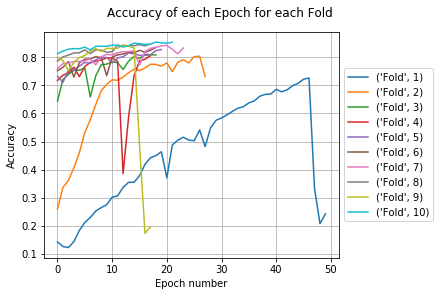

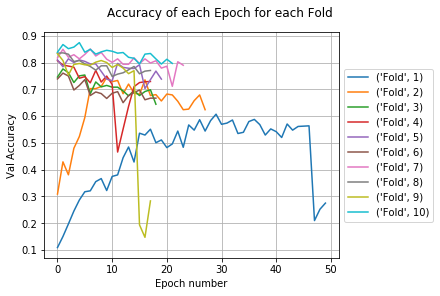

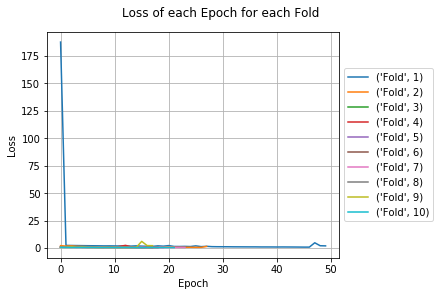

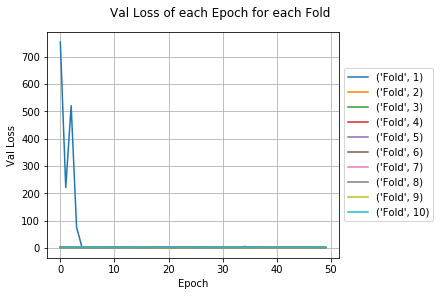

In [37]:
Graph_Epochs_model_3=Graph_func(Epoch_number,Epoch_array_accuracy_3,Val_accuracy_array_3,Loss_array_3,Val_Loss_array_3)

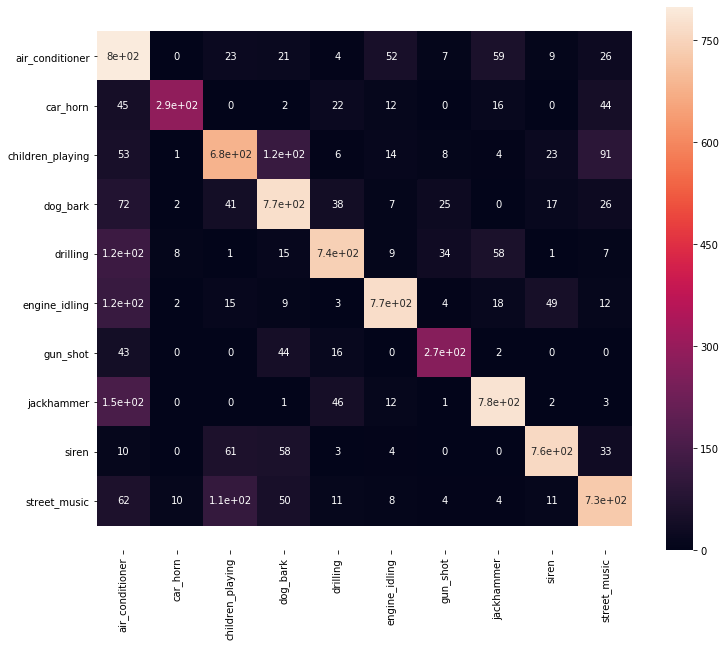

In [38]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [39]:
Table_model_3=table_maker(Fold_accuracy_3,end_array_3,Avg_Accuracy_3,Time_3)

  Fold  Accuracy  Time Taken
0    1  0.455753    196.3186
1    2  0.666633    111.3886
2    3  0.760168     77.5024
3    4  0.738145     73.6696
4    5  0.787391     71.5815
5    6  0.794006     63.4935
6    7  0.806240     91.3449
7    8  0.824803     69.7063
8    9  0.726089     69.1698
9   10  0.839190     85.5950

    Average Accuracy  Total Time
0          0.739842    909.7702


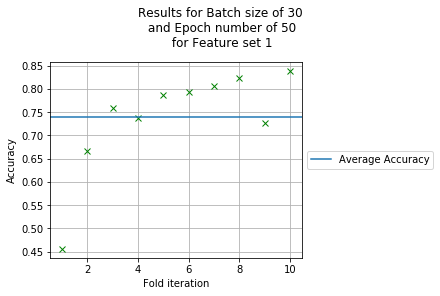

In [40]:
Graph_Avg_model_3=Graph_Avg_maker(Fold_accuracy_3,Avg_Accuracy_3)

### Model 3 no cross validation

In [41]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_3_history = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_3_no_cross=model_3.evaluate(X_test, y_test)
accuracy_model_3_no_cross = score_model_3_no_cross[1]
print(f"\nAccuracy of model 3 with no cross validation: {round(accuracy_model_3_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 3s - loss: 0.6558 - accuracy: 0.71 - ETA: 3s - loss: 0.3741 - accuracy: 0.85 - ETA: 3s - loss: 0.4476 - accuracy: 0.84 - ETA: 3s - loss: 0.4720 - accuracy: 0.85 - ETA: 2s - loss: 0.5097 - accuracy: 0.85 - ETA: 2s - loss: 0.5206 - accuracy: 0.84 - ETA: 2s - loss: 0.5300 - accuracy: 0.84 - ETA: 2s - loss: 0.5217 - accuracy: 0.84 - ETA: 2s - loss: 0.5359 - accuracy: 0.83 - ETA: 2s - loss: 0.5419 - accuracy: 0.83 - ETA: 2s - loss: 0.5421 - accuracy: 0.83 - ETA: 2s - loss: 0.5477 - accuracy: 0.83 - ETA: 2s - loss: 0.5361 - accuracy: 0.83 - ETA: 2s - loss: 0.5375 - accuracy: 0.83 - ETA: 2s - loss: 0.5272 - accuracy: 0.83 - ETA: 2s - loss: 0.5214 - accuracy: 0.83 - ETA: 2s - loss: 0.5237 - accuracy: 0.83 - ETA: 2s - loss: 0.5235 - accuracy: 0.83 - ETA: 2s - loss: 0.5174 - accuracy: 0.83 - ETA: 2s - loss: 0.5253 - accuracy: 0.83 - ETA: 2s - loss: 0.5214 - accuracy: 0.83 - ETA: 2s - loss:

7895/7895 [==============================] - ETA: 4s - loss: 0.3377 - accuracy: 0.90 - ETA: 3s - loss: 0.5142 - accuracy: 0.85 - ETA: 3s - loss: 0.5047 - accuracy: 0.85 - ETA: 3s - loss: 0.5272 - accuracy: 0.84 - ETA: 3s - loss: 0.5498 - accuracy: 0.82 - ETA: 3s - loss: 0.5403 - accuracy: 0.83 - ETA: 2s - loss: 0.5176 - accuracy: 0.84 - ETA: 2s - loss: 0.5343 - accuracy: 0.83 - ETA: 2s - loss: 0.5407 - accuracy: 0.83 - ETA: 2s - loss: 0.5257 - accuracy: 0.83 - ETA: 2s - loss: 0.5328 - accuracy: 0.83 - ETA: 2s - loss: 0.5272 - accuracy: 0.83 - ETA: 2s - loss: 0.5299 - accuracy: 0.83 - ETA: 2s - loss: 0.5272 - accuracy: 0.83 - ETA: 2s - loss: 0.5284 - accuracy: 0.82 - ETA: 2s - loss: 0.5312 - accuracy: 0.82 - ETA: 2s - loss: 0.5392 - accuracy: 0.82 - ETA: 2s - loss: 0.5396 - accuracy: 0.83 - ETA: 2s - loss: 0.5472 - accuracy: 0.82 - ETA: 2s - loss: 0.5470 - accuracy: 0.82 - ETA: 2s - loss: 0.5480 - accuracy: 0.82 - ETA: 2s - loss: 0.5496 - accuracy: 0.82 - ETA: 2s - loss: 0.5449 - accura

7895/7895 [==============================] - ETA: 4s - loss: 0.8218 - accuracy: 0.84 - ETA: 3s - loss: 0.5088 - accuracy: 0.84 - ETA: 3s - loss: 0.4690 - accuracy: 0.84 - ETA: 3s - loss: 0.4496 - accuracy: 0.85 - ETA: 3s - loss: 0.4498 - accuracy: 0.86 - ETA: 3s - loss: 0.4560 - accuracy: 0.86 - ETA: 3s - loss: 0.4462 - accuracy: 0.86 - ETA: 3s - loss: 0.4367 - accuracy: 0.86 - ETA: 3s - loss: 0.4258 - accuracy: 0.86 - ETA: 3s - loss: 0.4210 - accuracy: 0.86 - ETA: 3s - loss: 0.4103 - accuracy: 0.87 - ETA: 3s - loss: 0.4170 - accuracy: 0.86 - ETA: 3s - loss: 0.4305 - accuracy: 0.86 - ETA: 2s - loss: 0.4327 - accuracy: 0.86 - ETA: 2s - loss: 0.4447 - accuracy: 0.85 - ETA: 2s - loss: 0.4420 - accuracy: 0.85 - ETA: 2s - loss: 0.4527 - accuracy: 0.85 - ETA: 2s - loss: 0.4698 - accuracy: 0.84 - ETA: 2s - loss: 0.4899 - accuracy: 0.84 - ETA: 2s - loss: 0.4865 - accuracy: 0.84 - ETA: 2s - loss: 0.4860 - accuracy: 0.84 - ETA: 2s - loss: 0.4992 - accuracy: 0.83 - ETA: 2s - loss: 0.5033 - accura

7895/7895 [==============================] - ETA: 5s - loss: 0.6539 - accuracy: 0.78 - ETA: 3s - loss: 0.5929 - accuracy: 0.78 - ETA: 3s - loss: 0.5621 - accuracy: 0.78 - ETA: 3s - loss: 0.5662 - accuracy: 0.77 - ETA: 3s - loss: 0.5348 - accuracy: 0.79 - ETA: 3s - loss: 0.5213 - accuracy: 0.80 - ETA: 3s - loss: 0.5326 - accuracy: 0.80 - ETA: 3s - loss: 0.5495 - accuracy: 0.80 - ETA: 2s - loss: 0.5462 - accuracy: 0.80 - ETA: 2s - loss: 0.5420 - accuracy: 0.80 - ETA: 2s - loss: 0.5456 - accuracy: 0.80 - ETA: 2s - loss: 0.5450 - accuracy: 0.80 - ETA: 2s - loss: 0.5546 - accuracy: 0.80 - ETA: 2s - loss: 0.5470 - accuracy: 0.81 - ETA: 2s - loss: 0.5523 - accuracy: 0.81 - ETA: 2s - loss: 0.5534 - accuracy: 0.81 - ETA: 2s - loss: 0.5590 - accuracy: 0.81 - ETA: 2s - loss: 0.5707 - accuracy: 0.81 - ETA: 2s - loss: 0.5633 - accuracy: 0.81 - ETA: 2s - loss: 0.5642 - accuracy: 0.81 - ETA: 2s - loss: 0.5593 - accuracy: 0.81 - ETA: 2s - loss: 0.5598 - accuracy: 0.81 - ETA: 2s - loss: 0.5600 - accura

Epoch 12/30
7895/7895 [==============================] - ETA: 5s - loss: 0.3722 - accuracy: 0.87 - ETA: 3s - loss: 0.4384 - accuracy: 0.83 - ETA: 3s - loss: 0.3955 - accuracy: 0.86 - ETA: 3s - loss: 0.3943 - accuracy: 0.86 - ETA: 3s - loss: 0.4173 - accuracy: 0.85 - ETA: 3s - loss: 0.4477 - accuracy: 0.84 - ETA: 3s - loss: 0.4442 - accuracy: 0.84 - ETA: 3s - loss: 0.4585 - accuracy: 0.84 - ETA: 3s - loss: 0.4455 - accuracy: 0.85 - ETA: 3s - loss: 0.4468 - accuracy: 0.85 - ETA: 3s - loss: 0.4517 - accuracy: 0.84 - ETA: 3s - loss: 0.4540 - accuracy: 0.84 - ETA: 3s - loss: 0.4727 - accuracy: 0.84 - ETA: 3s - loss: 0.4786 - accuracy: 0.83 - ETA: 2s - loss: 0.4822 - accuracy: 0.83 - ETA: 2s - loss: 0.4740 - accuracy: 0.84 - ETA: 2s - loss: 0.4748 - accuracy: 0.84 - ETA: 2s - loss: 0.4706 - accuracy: 0.84 - ETA: 2s - loss: 0.4759 - accuracy: 0.84 - ETA: 2s - loss: 0.4771 - accuracy: 0.84 - ETA: 2s - loss: 0.4769 - accuracy: 0.84 - ETA: 2s - loss: 0.4736 - accuracy: 0.84 - ETA: 2s - loss: 0.4

7895/7895 [==============================] - ETA: 2s - loss: 0.4121 - accuracy: 0.93 - ETA: 2s - loss: 0.4460 - accuracy: 0.86 - ETA: 2s - loss: 0.4543 - accuracy: 0.85 - ETA: 2s - loss: 0.4474 - accuracy: 0.85 - ETA: 2s - loss: 0.4789 - accuracy: 0.84 - ETA: 2s - loss: 0.4504 - accuracy: 0.85 - ETA: 2s - loss: 0.4393 - accuracy: 0.85 - ETA: 2s - loss: 0.4195 - accuracy: 0.86 - ETA: 2s - loss: 0.4178 - accuracy: 0.86 - ETA: 2s - loss: 0.4398 - accuracy: 0.86 - ETA: 2s - loss: 0.4421 - accuracy: 0.85 - ETA: 2s - loss: 0.4382 - accuracy: 0.86 - ETA: 2s - loss: 0.4368 - accuracy: 0.86 - ETA: 2s - loss: 0.4292 - accuracy: 0.86 - ETA: 2s - loss: 0.4270 - accuracy: 0.86 - ETA: 2s - loss: 0.4282 - accuracy: 0.86 - ETA: 2s - loss: 0.4219 - accuracy: 0.86 - ETA: 2s - loss: 0.4256 - accuracy: 0.86 - ETA: 2s - loss: 0.4323 - accuracy: 0.86 - ETA: 2s - loss: 0.4287 - accuracy: 0.86 - ETA: 2s - loss: 0.4257 - accuracy: 0.86 - ETA: 2s - loss: 0.4244 - accuracy: 0.86 - ETA: 2s - loss: 0.4300 - accura

7895/7895 [==============================] - ETA: 3s - loss: 0.1269 - accuracy: 1.00 - ETA: 3s - loss: 0.4113 - accuracy: 0.87 - ETA: 3s - loss: 0.4114 - accuracy: 0.86 - ETA: 3s - loss: 0.3902 - accuracy: 0.86 - ETA: 3s - loss: 0.4492 - accuracy: 0.84 - ETA: 3s - loss: 0.4155 - accuracy: 0.85 - ETA: 3s - loss: 0.4181 - accuracy: 0.85 - ETA: 3s - loss: 0.4345 - accuracy: 0.85 - ETA: 3s - loss: 0.4290 - accuracy: 0.85 - ETA: 2s - loss: 0.4277 - accuracy: 0.85 - ETA: 2s - loss: 0.4282 - accuracy: 0.85 - ETA: 2s - loss: 0.4241 - accuracy: 0.86 - ETA: 2s - loss: 0.4350 - accuracy: 0.85 - ETA: 2s - loss: 0.4435 - accuracy: 0.85 - ETA: 2s - loss: 0.4647 - accuracy: 0.84 - ETA: 2s - loss: 0.4751 - accuracy: 0.84 - ETA: 2s - loss: 0.4719 - accuracy: 0.84 - ETA: 2s - loss: 0.4820 - accuracy: 0.84 - ETA: 2s - loss: 0.4855 - accuracy: 0.84 - ETA: 2s - loss: 0.4830 - accuracy: 0.84 - ETA: 2s - loss: 0.4795 - accuracy: 0.84 - ETA: 2s - loss: 0.4784 - accuracy: 0.84 - ETA: 2s - loss: 0.4816 - accura

7895/7895 [==============================] - ETA: 2s - loss: 0.0872 - accuracy: 0.96 - ETA: 3s - loss: 0.4401 - accuracy: 0.85 - ETA: 3s - loss: 0.3974 - accuracy: 0.86 - ETA: 3s - loss: 0.4228 - accuracy: 0.85 - ETA: 3s - loss: 0.4174 - accuracy: 0.85 - ETA: 3s - loss: 0.3911 - accuracy: 0.87 - ETA: 3s - loss: 0.3969 - accuracy: 0.87 - ETA: 3s - loss: 0.3861 - accuracy: 0.87 - ETA: 3s - loss: 0.3866 - accuracy: 0.87 - ETA: 3s - loss: 0.4041 - accuracy: 0.86 - ETA: 3s - loss: 0.4048 - accuracy: 0.86 - ETA: 3s - loss: 0.3984 - accuracy: 0.86 - ETA: 3s - loss: 0.3982 - accuracy: 0.86 - ETA: 3s - loss: 0.3989 - accuracy: 0.87 - ETA: 2s - loss: 0.4043 - accuracy: 0.86 - ETA: 2s - loss: 0.4075 - accuracy: 0.86 - ETA: 2s - loss: 0.4074 - accuracy: 0.86 - ETA: 2s - loss: 0.4042 - accuracy: 0.86 - ETA: 2s - loss: 0.4033 - accuracy: 0.86 - ETA: 2s - loss: 0.4125 - accuracy: 0.86 - ETA: 2s - loss: 0.4066 - accuracy: 0.86 - ETA: 2s - loss: 0.4066 - accuracy: 0.86 - ETA: 2s - loss: 0.4058 - accura

7895/7895 [==============================] - ETA: 4s - loss: 0.3270 - accuracy: 0.93 - ETA: 3s - loss: 0.4277 - accuracy: 0.88 - ETA: 3s - loss: 0.4513 - accuracy: 0.85 - ETA: 3s - loss: 0.4329 - accuracy: 0.85 - ETA: 3s - loss: 0.4322 - accuracy: 0.85 - ETA: 3s - loss: 0.4189 - accuracy: 0.86 - ETA: 3s - loss: 0.4299 - accuracy: 0.85 - ETA: 3s - loss: 0.4305 - accuracy: 0.85 - ETA: 2s - loss: 0.4330 - accuracy: 0.85 - ETA: 2s - loss: 0.4298 - accuracy: 0.85 - ETA: 2s - loss: 0.4325 - accuracy: 0.85 - ETA: 2s - loss: 0.4224 - accuracy: 0.86 - ETA: 2s - loss: 0.4189 - accuracy: 0.86 - ETA: 2s - loss: 0.4222 - accuracy: 0.86 - ETA: 2s - loss: 0.4373 - accuracy: 0.85 - ETA: 2s - loss: 0.4401 - accuracy: 0.85 - ETA: 2s - loss: 0.4371 - accuracy: 0.85 - ETA: 2s - loss: 0.4406 - accuracy: 0.85 - ETA: 2s - loss: 0.4442 - accuracy: 0.85 - ETA: 2s - loss: 0.4465 - accuracy: 0.85 - ETA: 2s - loss: 0.4450 - accuracy: 0.85 - ETA: 2s - loss: 0.4476 - accuracy: 0.85 - ETA: 2s - loss: 0.4499 - accura

Epoch 25/30
7895/7895 [==============================] - ETA: 2s - loss: 0.4909 - accuracy: 0.84 - ETA: 3s - loss: 0.3721 - accuracy: 0.86 - ETA: 3s - loss: 0.4347 - accuracy: 0.86 - ETA: 3s - loss: 0.4376 - accuracy: 0.86 - ETA: 3s - loss: 0.4252 - accuracy: 0.86 - ETA: 3s - loss: 0.4285 - accuracy: 0.87 - ETA: 3s - loss: 0.4511 - accuracy: 0.87 - ETA: 2s - loss: 0.4275 - accuracy: 0.87 - ETA: 3s - loss: 0.4186 - accuracy: 0.87 - ETA: 2s - loss: 0.4254 - accuracy: 0.87 - ETA: 2s - loss: 0.4164 - accuracy: 0.87 - ETA: 2s - loss: 0.4092 - accuracy: 0.87 - ETA: 2s - loss: 0.4094 - accuracy: 0.87 - ETA: 2s - loss: 0.4031 - accuracy: 0.87 - ETA: 2s - loss: 0.4009 - accuracy: 0.87 - ETA: 2s - loss: 0.3998 - accuracy: 0.87 - ETA: 2s - loss: 0.4097 - accuracy: 0.87 - ETA: 2s - loss: 0.4064 - accuracy: 0.87 - ETA: 2s - loss: 0.4055 - accuracy: 0.87 - ETA: 2s - loss: 0.4074 - accuracy: 0.87 - ETA: 2s - loss: 0.4215 - accuracy: 0.86 - ETA: 2s - loss: 0.4268 - accuracy: 0.86 - ETA: 2s - loss: 0.4

7895/7895 [==============================] - ETA: 2s - loss: 0.3080 - accuracy: 0.90 - ETA: 2s - loss: 0.4136 - accuracy: 0.86 - ETA: 2s - loss: 0.3724 - accuracy: 0.87 - ETA: 3s - loss: 0.4494 - accuracy: 0.86 - ETA: 2s - loss: 0.4561 - accuracy: 0.86 - ETA: 3s - loss: 0.4328 - accuracy: 0.86 - ETA: 2s - loss: 0.4540 - accuracy: 0.85 - ETA: 3s - loss: 0.4504 - accuracy: 0.86 - ETA: 3s - loss: 0.4483 - accuracy: 0.85 - ETA: 3s - loss: 0.4538 - accuracy: 0.85 - ETA: 3s - loss: 0.4539 - accuracy: 0.85 - ETA: 3s - loss: 0.4559 - accuracy: 0.85 - ETA: 2s - loss: 0.4404 - accuracy: 0.86 - ETA: 2s - loss: 0.4284 - accuracy: 0.86 - ETA: 2s - loss: 0.4285 - accuracy: 0.86 - ETA: 2s - loss: 0.4229 - accuracy: 0.86 - ETA: 2s - loss: 0.4204 - accuracy: 0.86 - ETA: 2s - loss: 0.4287 - accuracy: 0.86 - ETA: 2s - loss: 0.4225 - accuracy: 0.86 - ETA: 2s - loss: 0.4206 - accuracy: 0.86 - ETA: 2s - loss: 0.4176 - accuracy: 0.86 - ETA: 2s - loss: 0.4149 - accuracy: 0.86 - ETA: 2s - loss: 0.4135 - accura

837/837 [==============================] - ETA:  - ETA:  - ETA:  - 0s 175us/step

Accuracy of model 3 with no cross validation: 0.795


## Model 4

In [42]:
#adding layers and forming the model_1
#forming model_1
model_4=Sequential()

model_4.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(24,4,1)))
model_4.add(MaxPooling2D(padding="same"))

model_4.add(Flatten())

model_4.add(Dense(10,activation="softmax"))
#compiling
Model_4=model_4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [43]:
Accuracy_array_4=[]
accuracy_total_4=0
end_array_4=[]

Epoch_array_accuracy_4=[]
Loss_array_4=[]
Fold_accuracy_4=[]

Val_accuracy_array_4=[]
Val_Loss_array_4=[]

Avg_Accuracy_4=[]
Time_4=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_4=Model_run_nn_es(Model_4,model_4,X_folds_10,Y_folds_10,Accuracy_array_4,
                     accuracy_total_4,end_array_4,Epoch_array_accuracy_4,Loss_array_4,
                     Fold_accuracy_4,Val_accuracy_array_4,Val_Loss_array_4, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_4=Model_4[0]
Time_4=Model_4[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4, 1) (7859, 10) (873, 24, 4, 1) (873, 10)
Accuracy of Fold 1 is 0.7212774753570557
Time to train Fold 1 : 97.6533 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4, 1) (7844, 10) (888, 24, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.8835486769676208
Time to train Fold 2 : 33.8241 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4, 1) (7807, 10) (925, 24, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.8867818117141724
Time to train Fold 3 : 37.121 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4, 1) (7742, 10) (990, 24, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.8886000514030457
Time to train Fold 4 : 42.9291 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4, 1) (7796, 10) (936, 24, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.8981798887252808
Time to train Fold 5 : 36.2001 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4, 1) (7909, 10) (823

In [44]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.6067955545436933, 0.6157452190996261, 0.6082474226804123, 0.6082474226804123
2, 0.8677728061689051, 0.8746154495824088, 0.8682432432432432, 0.8682432432432432
3, 0.8168844811850783, 0.8283274971128792, 0.8194594594594594, 0.8194594594594594
4, 0.7994178276346682, 0.8190494455536874, 0.797979797979798, 0.797979797979798
5, 0.8493592310268775, 0.8574553894001278, 0.8482905982905983, 0.8482905982905983
6, 0.8091703633606951, 0.8143495324796126, 0.8080194410692588, 0.8080194410692588
7, 0.8871176284794602, 0.8982704924753485, 0.8866348448687351, 0.8866348448687351
8, 0.8595198936164941, 0.8671486342184381, 0.8598014888337469, 0.8598014888337469
9, 0.8536148594607829, 0.8664855225514091, 0.8541666666666666, 0.8541666666666666
10, 0.8901525760499911, 0.8966543220405824, 0.8888888888888888, 0.8888888888888888


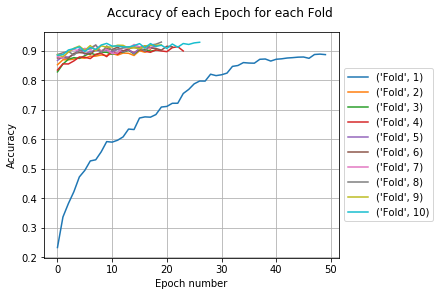

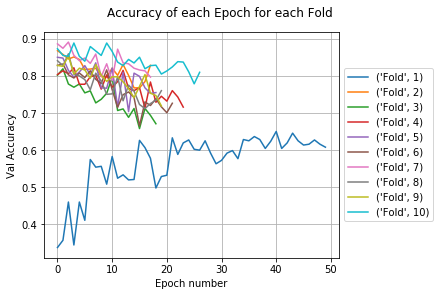

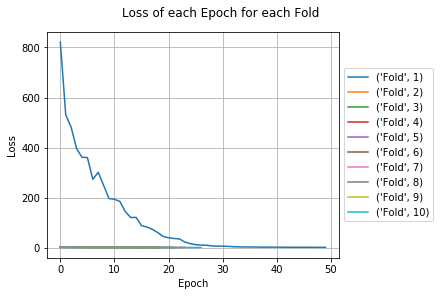

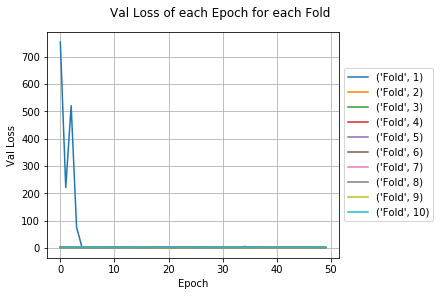

In [45]:
Graph_Epochs_model_4=Graph_func(Epoch_number,Epoch_array_accuracy_4,Val_accuracy_array_4,Loss_array_4,Val_Loss_array_4)

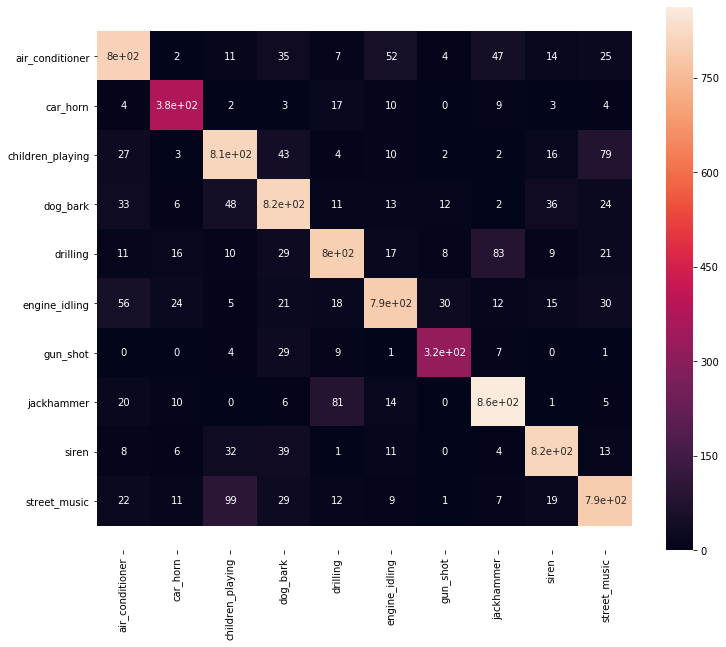

In [46]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [47]:
Table_model_4=table_maker(Fold_accuracy_4,end_array_4,Avg_Accuracy_4,Time_4)

  Fold  Accuracy  Time Taken
0    1  0.721277     97.6533
1    2  0.883549     33.8241
2    3  0.886782     37.1210
3    4  0.888600     42.9291
4    5  0.898180     36.2001
5    6  0.901367     38.7716
6    7  0.903344     35.6340
7    8  0.907040     36.8279
8    9  0.910093     39.4950
9   10  0.914357     53.1588

    Average Accuracy  Total Time
0          0.881459    451.6149


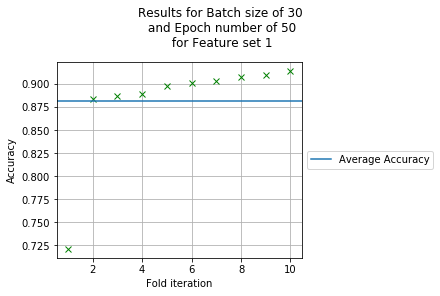

In [48]:
Graph_Avg_model_4=Graph_Avg_maker(Fold_accuracy_4,Avg_Accuracy_4)

In [49]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_4_history = model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_4_no_cross=model_4.evaluate(X_test, y_test)
accuracy_model_4_no_cross = score_model_4_no_cross[1]
print(f"\nAccuracy of model 4 with no cross validation: {round(accuracy_model_4_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 3s - loss: 0.2007 - accuracy: 0.96 - ETA: 1s - loss: 0.3104 - accuracy: 0.94 - ETA: 1s - loss: 0.2696 - accuracy: 0.94 - ETA: 1s - loss: 0.2672 - accuracy: 0.94 - ETA: 1s - loss: 0.2372 - accuracy: 0.94 - ETA: 1s - loss: 0.2824 - accuracy: 0.94 - ETA: 1s - loss: 0.2722 - accuracy: 0.94 - ETA: 1s - loss: 0.3273 - accuracy: 0.94 - ETA: 1s - loss: 0.3763 - accuracy: 0.94 - ETA: 1s - loss: 0.3821 - accuracy: 0.93 - ETA: 1s - loss: 0.3965 - accuracy: 0.93 - ETA: 1s - loss: 0.3918 - accuracy: 0.93 - ETA: 1s - loss: 0.3904 - accuracy: 0.93 - ETA: 0s - loss: 0.4204 - accuracy: 0.93 - ETA: 0s - loss: 0.4183 - accuracy: 0.93 - ETA: 0s - loss: 0.4162 - accuracy: 0.93 - ETA: 0s - loss: 0.4192 - accuracy: 0.93 - ETA: 0s - loss: 0.4481 - accuracy: 0.93 - ETA: 0s - loss: 0.4556 - accuracy: 0.93 - ETA: 0s - loss: 0.4658 - accuracy: 0.92 - ETA: 0s - loss: 0.4695 - accuracy: 0.92 - ETA: 0s - loss:

7895/7895 [==============================] - ETA: 1s - loss: 2.1854 - accuracy: 0.81 - ETA: 2s - loss: 0.6880 - accuracy: 0.90 - ETA: 1s - loss: 0.5905 - accuracy: 0.91 - ETA: 1s - loss: 0.5492 - accuracy: 0.92 - ETA: 1s - loss: 0.9527 - accuracy: 0.92 - ETA: 1s - loss: 0.8406 - accuracy: 0.92 - ETA: 1s - loss: 0.7513 - accuracy: 0.92 - ETA: 1s - loss: 0.7983 - accuracy: 0.92 - ETA: 1s - loss: 0.7661 - accuracy: 0.92 - ETA: 1s - loss: 0.7433 - accuracy: 0.92 - ETA: 1s - loss: 0.7175 - accuracy: 0.92 - ETA: 1s - loss: 0.6951 - accuracy: 0.92 - ETA: 1s - loss: 0.6959 - accuracy: 0.92 - ETA: 1s - loss: 0.6648 - accuracy: 0.92 - ETA: 0s - loss: 0.6332 - accuracy: 0.92 - ETA: 0s - loss: 0.6362 - accuracy: 0.92 - ETA: 0s - loss: 0.6336 - accuracy: 0.92 - ETA: 0s - loss: 0.6533 - accuracy: 0.92 - ETA: 0s - loss: 0.6475 - accuracy: 0.92 - ETA: 0s - loss: 0.6425 - accuracy: 0.92 - ETA: 0s - loss: 0.6412 - accuracy: 0.92 - ETA: 0s - loss: 0.6369 - accuracy: 0.92 - ETA: 0s - loss: 0.6249 - accura

7895/7895 [==============================] - ETA: 1s - loss: 0.0776 - accuracy: 0.93 - ETA: 1s - loss: 0.4224 - accuracy: 0.91 - ETA: 1s - loss: 0.5875 - accuracy: 0.91 - ETA: 1s - loss: 0.6486 - accuracy: 0.90 - ETA: 1s - loss: 0.6276 - accuracy: 0.90 - ETA: 1s - loss: 0.5755 - accuracy: 0.91 - ETA: 1s - loss: 0.5493 - accuracy: 0.91 - ETA: 1s - loss: 0.5563 - accuracy: 0.91 - ETA: 0s - loss: 0.5607 - accuracy: 0.91 - ETA: 0s - loss: 0.5394 - accuracy: 0.92 - ETA: 0s - loss: 0.5244 - accuracy: 0.92 - ETA: 0s - loss: 0.5173 - accuracy: 0.92 - ETA: 0s - loss: 0.4973 - accuracy: 0.92 - ETA: 0s - loss: 0.4971 - accuracy: 0.92 - ETA: 0s - loss: 0.5424 - accuracy: 0.92 - ETA: 0s - loss: 0.5407 - accuracy: 0.92 - ETA: 0s - loss: 0.5339 - accuracy: 0.92 - ETA: 0s - loss: 0.5432 - accuracy: 0.92 - ETA: 0s - loss: 0.5265 - accuracy: 0.92 - ETA: 0s - loss: 0.5301 - accuracy: 0.92 - ETA: 0s - loss: 0.5472 - accuracy: 0.92 - ETA: 0s - loss: 0.5565 - accuracy: 0.92 - ETA: 0s - loss: 0.6135 - accura

Epoch 16/30
7895/7895 [==============================] - ETA: 2s - loss: 0.9890 - accuracy: 0.87 - ETA: 2s - loss: 0.8707 - accuracy: 0.90 - ETA: 1s - loss: 0.7592 - accuracy: 0.91 - ETA: 1s - loss: 0.7111 - accuracy: 0.91 - ETA: 1s - loss: 0.7610 - accuracy: 0.91 - ETA: 1s - loss: 0.7633 - accuracy: 0.91 - ETA: 1s - loss: 0.7036 - accuracy: 0.91 - ETA: 1s - loss: 0.6754 - accuracy: 0.91 - ETA: 1s - loss: 0.8808 - accuracy: 0.91 - ETA: 1s - loss: 0.8342 - accuracy: 0.91 - ETA: 1s - loss: 0.8222 - accuracy: 0.91 - ETA: 1s - loss: 0.7888 - accuracy: 0.91 - ETA: 1s - loss: 0.8401 - accuracy: 0.91 - ETA: 1s - loss: 0.7972 - accuracy: 0.91 - ETA: 1s - loss: 0.7841 - accuracy: 0.91 - ETA: 1s - loss: 0.8548 - accuracy: 0.91 - ETA: 1s - loss: 0.8472 - accuracy: 0.91 - ETA: 1s - loss: 0.8611 - accuracy: 0.91 - ETA: 1s - loss: 0.8690 - accuracy: 0.91 - ETA: 1s - loss: 0.8682 - accuracy: 0.91 - ETA: 0s - loss: 0.8659 - accuracy: 0.91 - ETA: 0s - loss: 0.8793 - accuracy: 0.91 - ETA: 0s - loss: 0.8

7895/7895 [==============================] - ETA: 1s - loss: 1.0543 - accuracy: 0.90 - ETA: 1s - loss: 0.3499 - accuracy: 0.95 - ETA: 1s - loss: 0.3677 - accuracy: 0.94 - ETA: 1s - loss: 0.4143 - accuracy: 0.93 - ETA: 1s - loss: 0.4253 - accuracy: 0.93 - ETA: 1s - loss: 0.4074 - accuracy: 0.93 - ETA: 1s - loss: 0.4250 - accuracy: 0.93 - ETA: 1s - loss: 0.4188 - accuracy: 0.93 - ETA: 1s - loss: 0.4026 - accuracy: 0.93 - ETA: 1s - loss: 0.4193 - accuracy: 0.93 - ETA: 1s - loss: 0.4132 - accuracy: 0.93 - ETA: 1s - loss: 0.3943 - accuracy: 0.93 - ETA: 1s - loss: 0.4036 - accuracy: 0.93 - ETA: 1s - loss: 0.4076 - accuracy: 0.93 - ETA: 1s - loss: 0.4172 - accuracy: 0.93 - ETA: 1s - loss: 0.4097 - accuracy: 0.93 - ETA: 0s - loss: 0.3908 - accuracy: 0.93 - ETA: 0s - loss: 0.3818 - accuracy: 0.93 - ETA: 0s - loss: 0.3751 - accuracy: 0.93 - ETA: 0s - loss: 0.3676 - accuracy: 0.94 - ETA: 0s - loss: 0.3645 - accuracy: 0.94 - ETA: 0s - loss: 0.3593 - accuracy: 0.94 - ETA: 0s - loss: 0.3685 - accura

7895/7895 [==============================] - ETA: 1s - loss: 1.0253 - accuracy: 0.81 - ETA: 1s - loss: 0.4154 - accuracy: 0.92 - ETA: 1s - loss: 0.5033 - accuracy: 0.91 - ETA: 1s - loss: 0.5480 - accuracy: 0.92 - ETA: 1s - loss: 0.5232 - accuracy: 0.92 - ETA: 1s - loss: 0.5956 - accuracy: 0.91 - ETA: 1s - loss: 0.6294 - accuracy: 0.91 - ETA: 1s - loss: 0.6246 - accuracy: 0.91 - ETA: 1s - loss: 0.5909 - accuracy: 0.91 - ETA: 1s - loss: 0.5761 - accuracy: 0.91 - ETA: 1s - loss: 0.5894 - accuracy: 0.91 - ETA: 1s - loss: 0.5867 - accuracy: 0.91 - ETA: 1s - loss: 0.5648 - accuracy: 0.92 - ETA: 1s - loss: 0.5470 - accuracy: 0.92 - ETA: 1s - loss: 0.5595 - accuracy: 0.92 - ETA: 1s - loss: 0.5470 - accuracy: 0.92 - ETA: 1s - loss: 0.5335 - accuracy: 0.92 - ETA: 1s - loss: 0.5254 - accuracy: 0.92 - ETA: 1s - loss: 0.5091 - accuracy: 0.92 - ETA: 0s - loss: 0.4971 - accuracy: 0.92 - ETA: 0s - loss: 0.4841 - accuracy: 0.92 - ETA: 0s - loss: 0.4696 - accuracy: 0.92 - ETA: 0s - loss: 0.4570 - accura

837/837 [==============================] - ETA:  - ETA:  - 0s 93us/step

Accuracy of model 4 with no cross validation: 0.8112


### Model comparisson

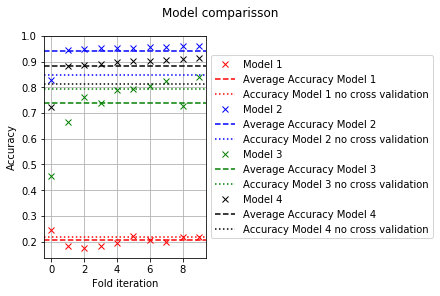

In [50]:
%matplotlib inline

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

ax1.plot(Fold_accuracy,"rx",label="Model 1")
ax1.axhline(y=Avg_Accuracy,label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")


ax1.plot(Fold_accuracy_2,"bx",label="Model 2")
ax1.axhline(y=Avg_Accuracy_2,label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")


ax1.plot(Fold_accuracy_3,"gx",label="Model 3")
ax1.axhline(y=Avg_Accuracy_3,label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

ax1.plot(Fold_accuracy_4,"kx",label="Model 4")
ax1.axhline(y=Avg_Accuracy_4,label='Average Accuracy Model 4',color='k',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='k',ls=":")

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_folds, Y_folds = data_processor_log_reg(X_folds,Y_folds)

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy of logistic regression classifier on test set: 0.66
